Finally reextracting every g140m spectrum

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from matplotlib import cm
from scipy import interpolate
from astropy.modeling import models, fitting
from astropy.units import cds
cds.enable()

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [3]:
path = '/media/david/2tb_ext_hd/hddata/mega_muscles/t1_g140m/data/'
outpath = '/media/david/2tb_ext_hd/hddata/mega_muscles/t1_g140m/output/'

In [4]:
centers = Table.read('trace_centers_2024.ecsv')

In [5]:
def build_trace_grid(SPTRCTAB, grating, cenwave):
    """
    Extends a grid of trace displacements to cover all y positions
    """
    data = fits.getdata(SPTRCTAB, 1)
    tracedata = data[(data['OPT_ELEM']==grating) & (data['CENWAVE'] == cenwave)]
    all_y = np.arange(len(tracedata[0]['A2DISPL']))
    grid = interpolate.interp1d(tracedata['A2CENTER'], tracedata['A2DISPL'], axis=0, fill_value='extrapolate')(all_y)
    tracegrid = [a+b for a, b in zip(grid, all_y)] 
    return tracegrid

def get_a2center(x, y, tracegrid):
    """
    get the trace a2center at a1center
    """
    xcol = np.array(tracegrid)[:,int(x)]
    xind = (np.abs(xcol - y)).argmin()
    a2center = xind + 1 #calstis is 1-indexed 
    return a2center

In [6]:
import stistools
os.environ['oref'] = path

The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/stsci/tools/nmpfit.py:8: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/stsci/tools/gfit.py:18: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


In [53]:
progs = []

for i, root in enumerate(centers['ROOTNAME']):
    flt = '{}/{}_flt.fits'.format(path, root)
    hdr = fits.getheader(flt, 0)
    progs.append(hdr['PROPOSID'])

print(np.unique(progs))
print(len(centers))
print(len(centers[centers['UNCERTAIN'] == 1.0]))
print(len(centers[centers['UNCERTAIN'] != 1.0]))

[14493 14900 15071 15304]
119
13
106


In [36]:


for i, root in enumerate(centers['ROOTNAME']):
    if centers['UNCERTAIN'][i] != 1.0:
        flt = '{}/{}_flt.fits'.format(path, root)
        SPTRCTAB = fits.getheader(flt,0)['SPTRCTAB']
        grating = fits.getheader(flt,0)['OPT_ELEM']
        cenwave = fits.getheader(flt,0)['CENWAVE']
        tracegrid = build_trace_grid(path+SPTRCTAB[5:], grating, cenwave)
        rootname = fits.getheader(flt)['ROOTNAME'] 
        outname = '{}{}_new_x1d.fits'.format(outpath, rootname)
        if os.path.exists(outname):
            os.remove(outname)
        a2center = get_a2center(centers['XCOL'][i], centers['A2CENTER'][i], tracegrid)
        # print(a2center)
        # stistools.x1d.x1d(flt, output = outname, trailer='{}{}_new.trl'.format(outpath, rootname), a2center=a2center, maxsrch=0,  bk1offst=30,  bk2offst=30, bksorder=2, bksmode='off')

In [15]:
    # new_x1ds = glob.glob('{}*new_x1d.fits'.format(outpath))
# print(len(new_x1ds))
# # fig, ax = plt.subplots()

# for x in new_x1ds:
#     fig, ax = plt.subplots()
#     print(fits.getheader(x, 0)['ROOTNAME'])
#     data = fits.getdata(x, 1)[0]
#     w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
#     ax.step(w, f, where='mid')
#     ax.step(w, e, where='mid', alpha=0.5)
#     plt.show()

#     ax.set_xlim(1211, 1219)
#     ax.set_ylim(-1e-15, 1.3e-14)

(-1e-15, 1.3e-14)

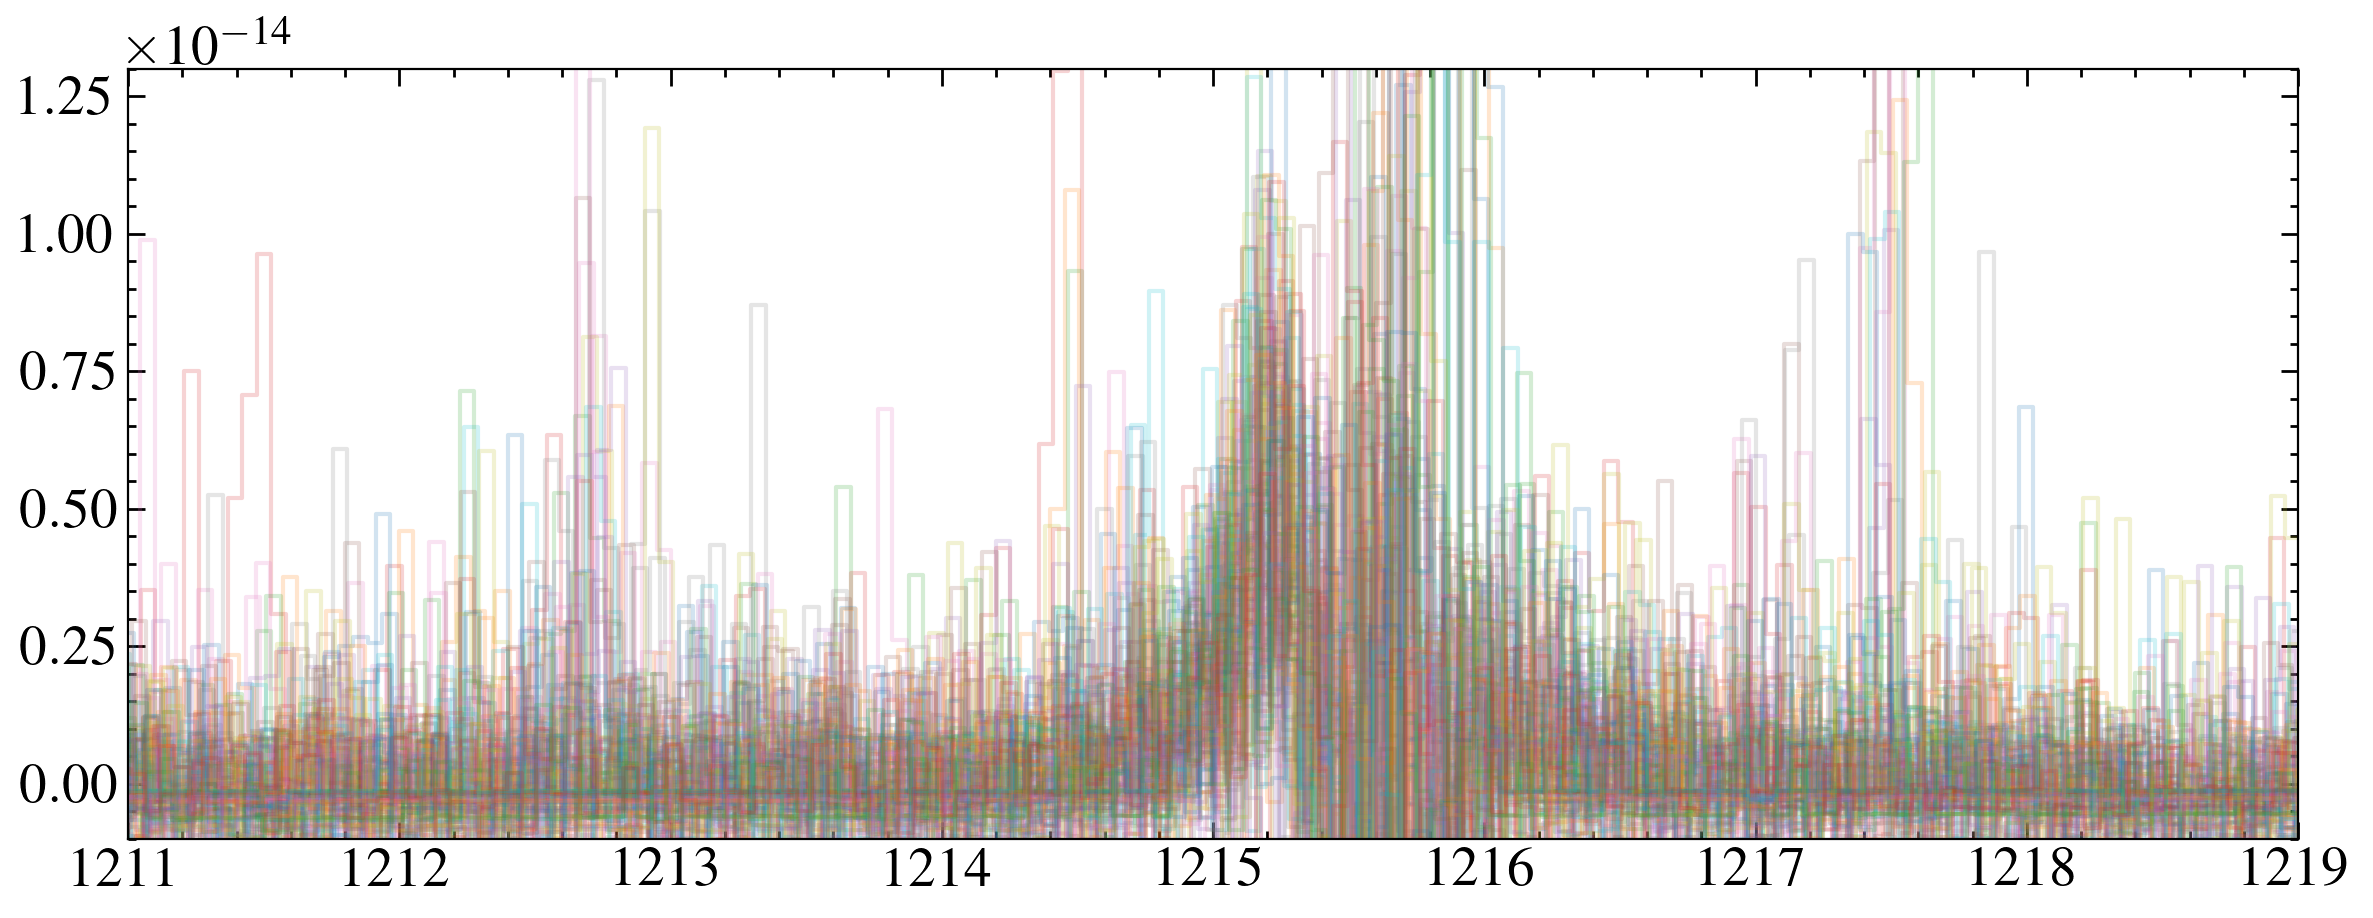

In [16]:
# new_x1ds = glob.glob('{}*new_x1d.fits'.format(outpath))
# # print(len(new_x1ds))
# fig, ax = plt.subplots()

# for x in new_x1ds:
#     # fig, ax = plt.subplots()
#     # print(fits.getheader(x, 0)['ROOTNAME'])
#     data = fits.getdata(x, 1)[0]
#     w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
#     ax.step(w, f, where='mid', alpha=0.2)
#     # ax.step(w, e, where='mid', alpha=0.5)
#     # plt.show()

# ax.set_xlim(1211, 1219)
# ax.set_ylim(-1e-15, 1.3e-14)

In [17]:
# for i, root in enumerate(centers['ROOTNAME']):
#     if centers['UNCERTAIN'][i] == 1.0:
#         print('rm ' +root+'_new_x1d.fits')

(1211.0, 1219.0)

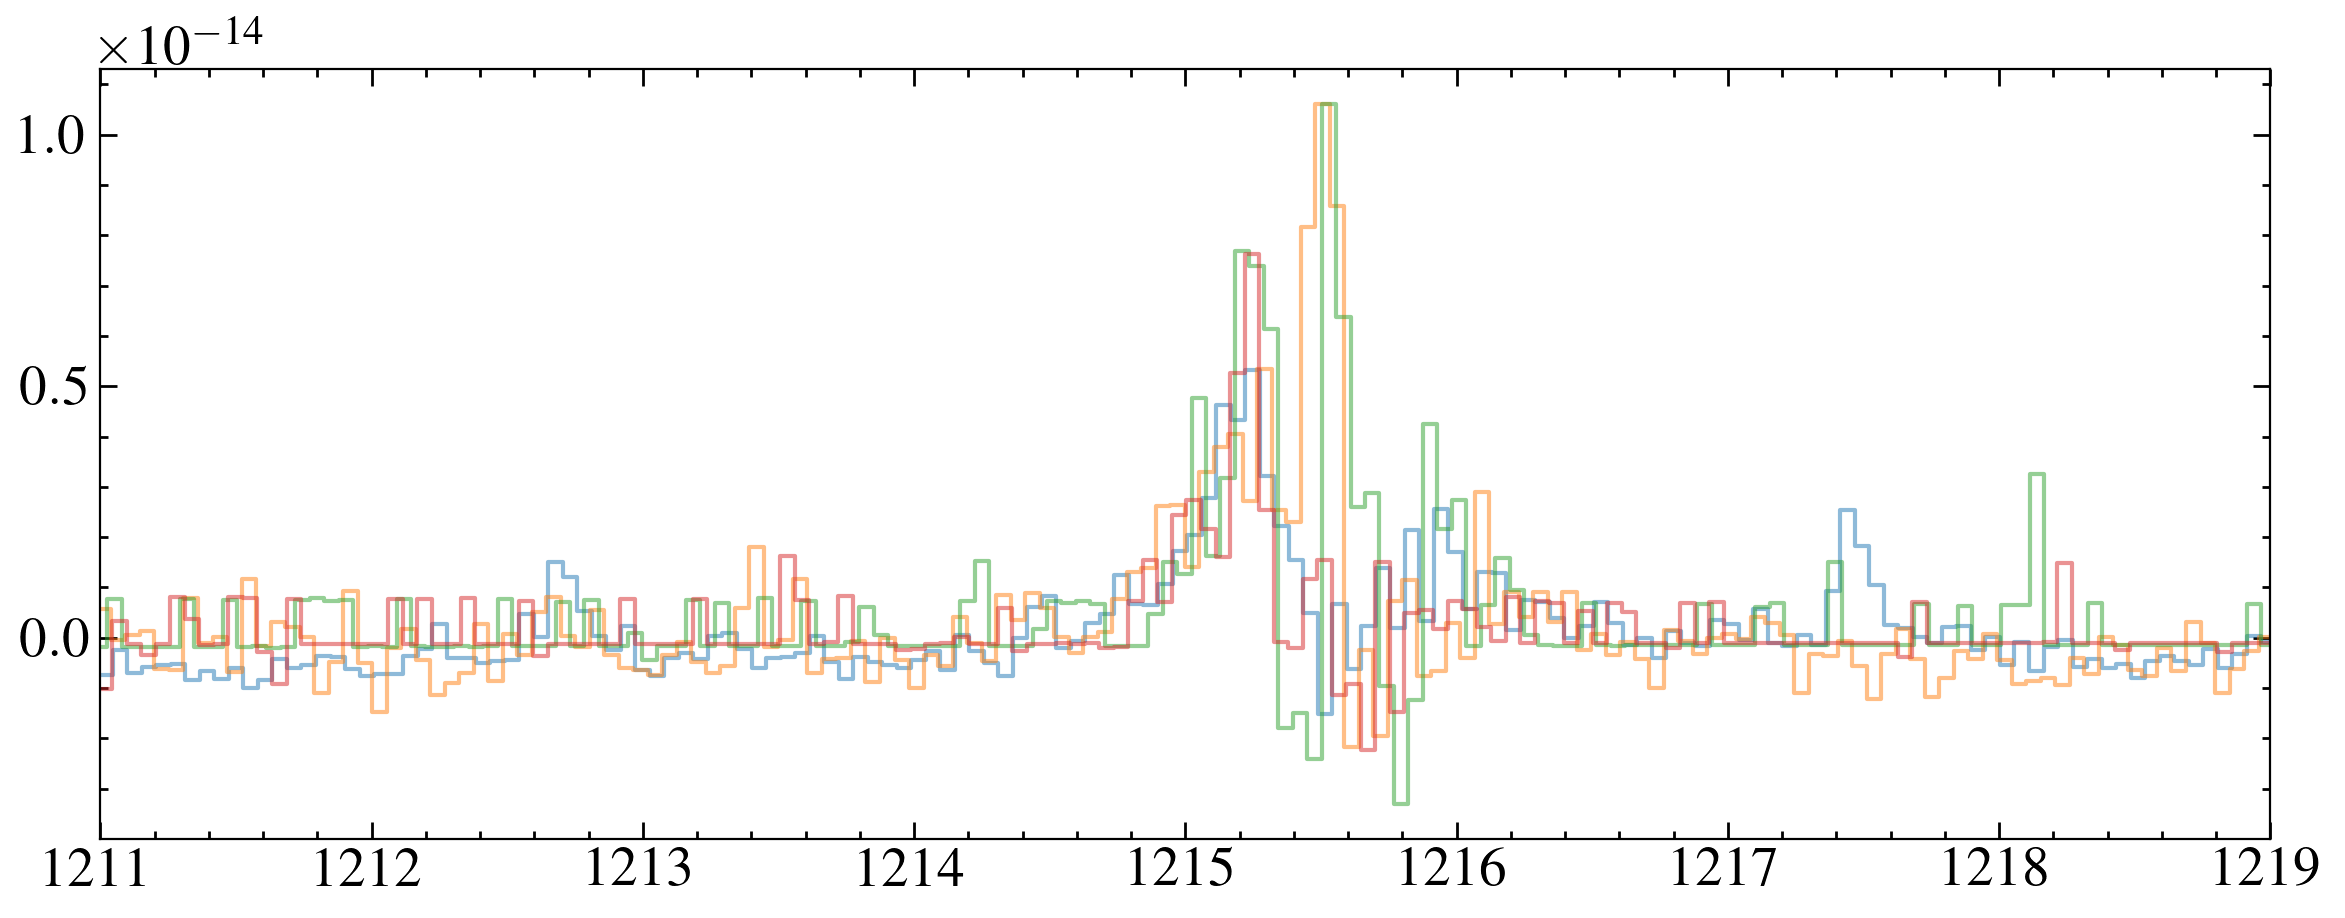

In [66]:
# hasppath = '/media/david/2tb_ext_hd/hddata/mega_muscles/t1_g140m/output/hasp/hasp_out/'
# hasps = ['hst_15304_stis_2mass-j23062928-0502285_g140m_odhs_cspec.fits','hst_15071_stis_2mass-j23062928-0502285_g140m_odlm_cspec.fits',
#         'hst_14900_stis_2mass-j23062928-0502285-copy_g140m_oddv_cspec.fits','hst_14493_stis_2mass-j23062928-0502285_g140m_od3v_cspec.fits']

# fig, ax = plt.subplots()
# for hasp in hasps:
#     # fig, ax = plt.subplots()
    
#     data = fits.getdata('{}{}'.format(hasppath, hasp), 1)[0]
#     w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
#     ax.step(w, f, where='mid', alpha=0.5)
#     # ax.step(w, e, where='mid', alpha=0.5)
    
#     # plt.show()


# ax.set_xlim(1211, 1219)
# # ax.set_ylim(-1e-15, 1.3e-14)

In [37]:
#hack same program and target for hasp coadd, see if that works

input_x1ds = glob.glob('/media/david/2tb_ext_hd/hddata/mega_muscles/t1_g140m/output/*x1d.fits')

for x in input_x1ds:
    hdul = fits.open(x)
    hdul[0].header['TARGNAME'] = 'TRAPPIST-1'
    root = hdul[0].header['ROOTNAME']
    hdul[0].header['PROPOSID'] = 1
    hdul.writeto('/media/david/2tb_ext_hd/hddata/mega_muscles/t1_g140m/output/hasp_in/{}_fixed_x1d.fits'.format(root), overwrite=True)
    hdul.close()

In [34]:
# hasppath = '/media/david/2tb_ext_hd/hddata/mega_muscles/t1_g140m/output/hasp/hasp_out/'
# hasps =['hst_1_stis_trappist-1_g140m_odlm_cspec.fits'] 
# # hasps = ['hst_15304_stis_2mass-j23062928-0502285_g140m_odhs_cspec.fits','hst_15071_stis_2mass-j23062928-0502285_g140m_odlm_cspec.fits',
# #         'hst_14900_stis_2mass-j23062928-0502285-copy_g140m_oddv_cspec.fits','hst_14493_stis_2mass-j23062928-0502285_g140m_od3v_cspec.fits', 'hst_1_stis_trappist-1_g140m_odlm_cspec.fits']


# fig, ax = plt.subplots()
# for hasp in hasps:
#     # fig, ax = plt.subplots()
    
#     data = fits.getdata('{}{}'.format(hasppath, hasp), 1)[0]
#     w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
#     if hasp =='hst_1_stis_trappist-1_g140m_odlm_cspec.fits':
#         ax.step(w, f, where='mid', c='k',  zorder=10)
#         ax.step(w, e, where='mid', alpha=0.5)
        
#     else:
#         ax.step(w, f, where='mid', alpha=0.5)
    
    
#     # plt.show()


# # ax.set_xlim(1211, 1219)
# # ax.set_ylim(-1e-15, 1.3e-14)

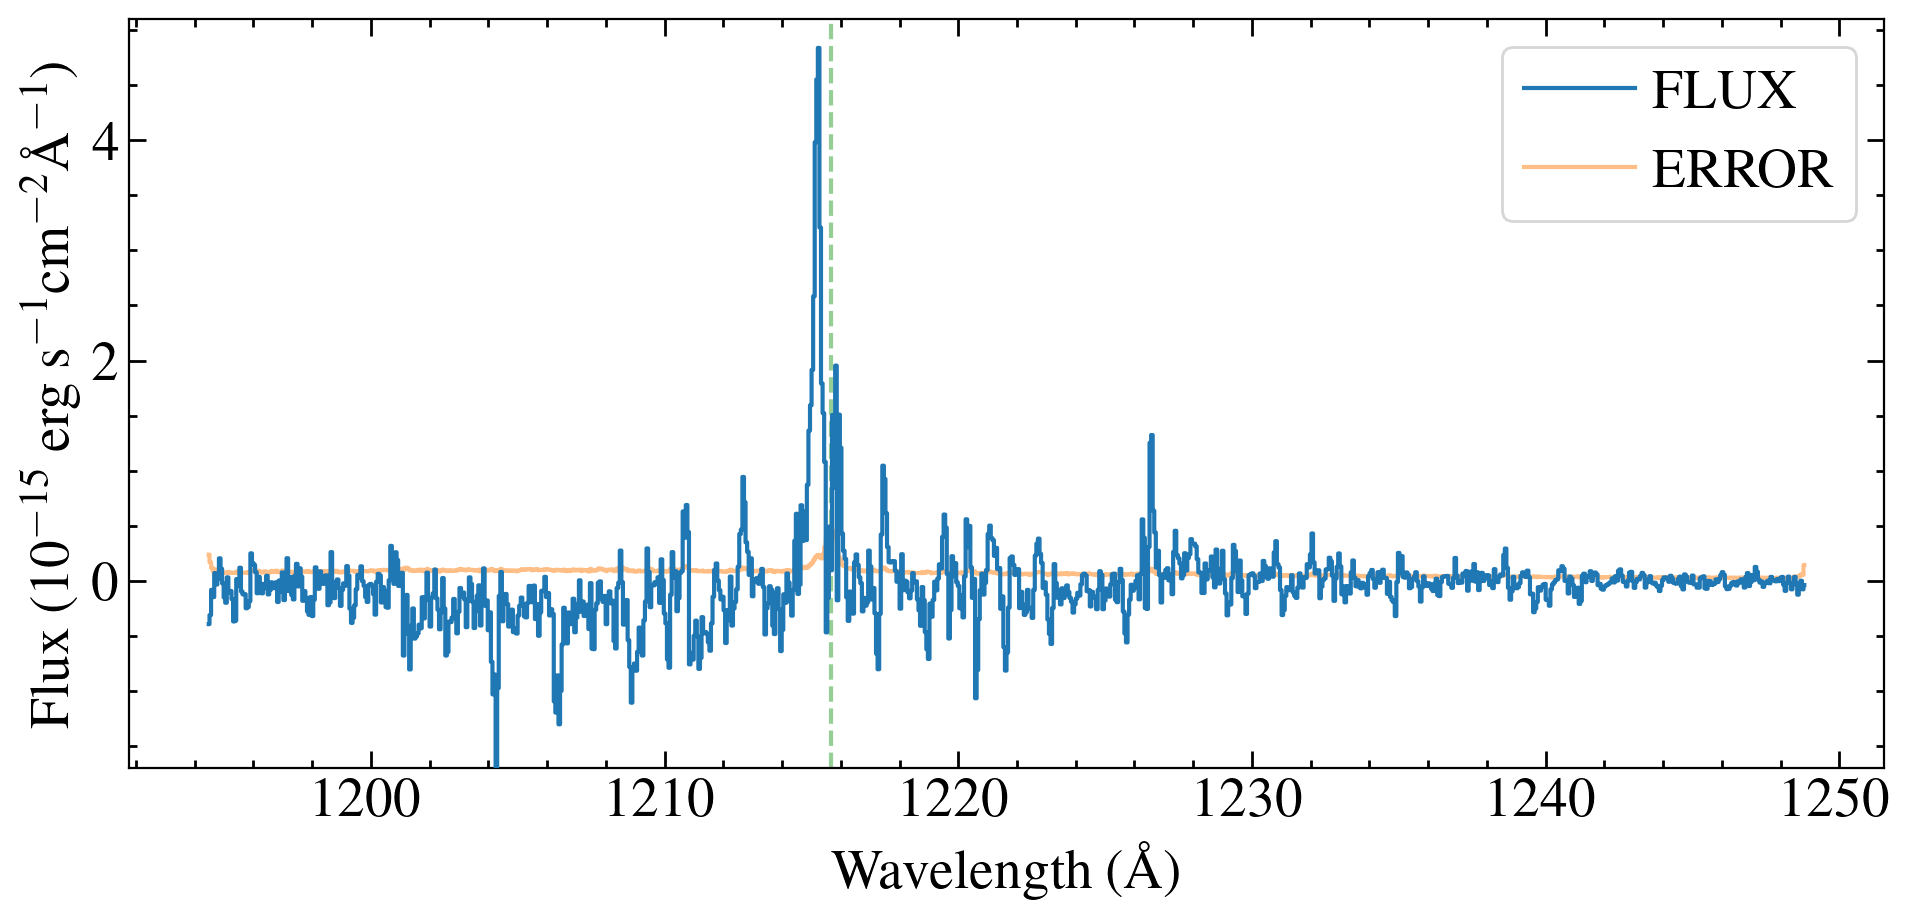

In [51]:
lya = 1215.67
scale = 1e15
hasppath = '/media/david/2tb_ext_hd/hddata/mega_muscles/t1_g140m/output/hasp_out/'
hasp ='hst_1_stis_trappist-1_g140m_odlm_cspec.fits' 

fig, ax = plt.subplots(figsize=(10, 5))

data = fits.getdata('{}{}'.format(hasppath, hasp), 1)[0]
w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
ax.step(w, f*scale, where='mid',  zorder=10, label='FLUX')
ax.step(w, e*scale, where='mid', alpha=0.5, label='ERROR')
# ax.errorbar(w, f, yerr=e, errorevery=2, drawstyle='steps-mid')

# ax.set_xlim(1211.1, 1219.9)
ax.set_ylim(-1.7, 5.1)

ax.set_xlabel('Wavelength (\AA)')
ax.set_ylabel('Flux (10$^{-15}$ erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')

ax.legend(frameon=True)
ax.axvline(lya, ls='--', c='C2', alpha=0.5)

fig.tight_layout()

In [94]:
exptime= np.median(data['EFF_EXPTIME'])*u.s
print(exptime)
print(exptime.to(u.h))
print(exptime.to(u.d))


211354.765625 s
58.70965711805555 h
2.4462357132523147 d


20.4459


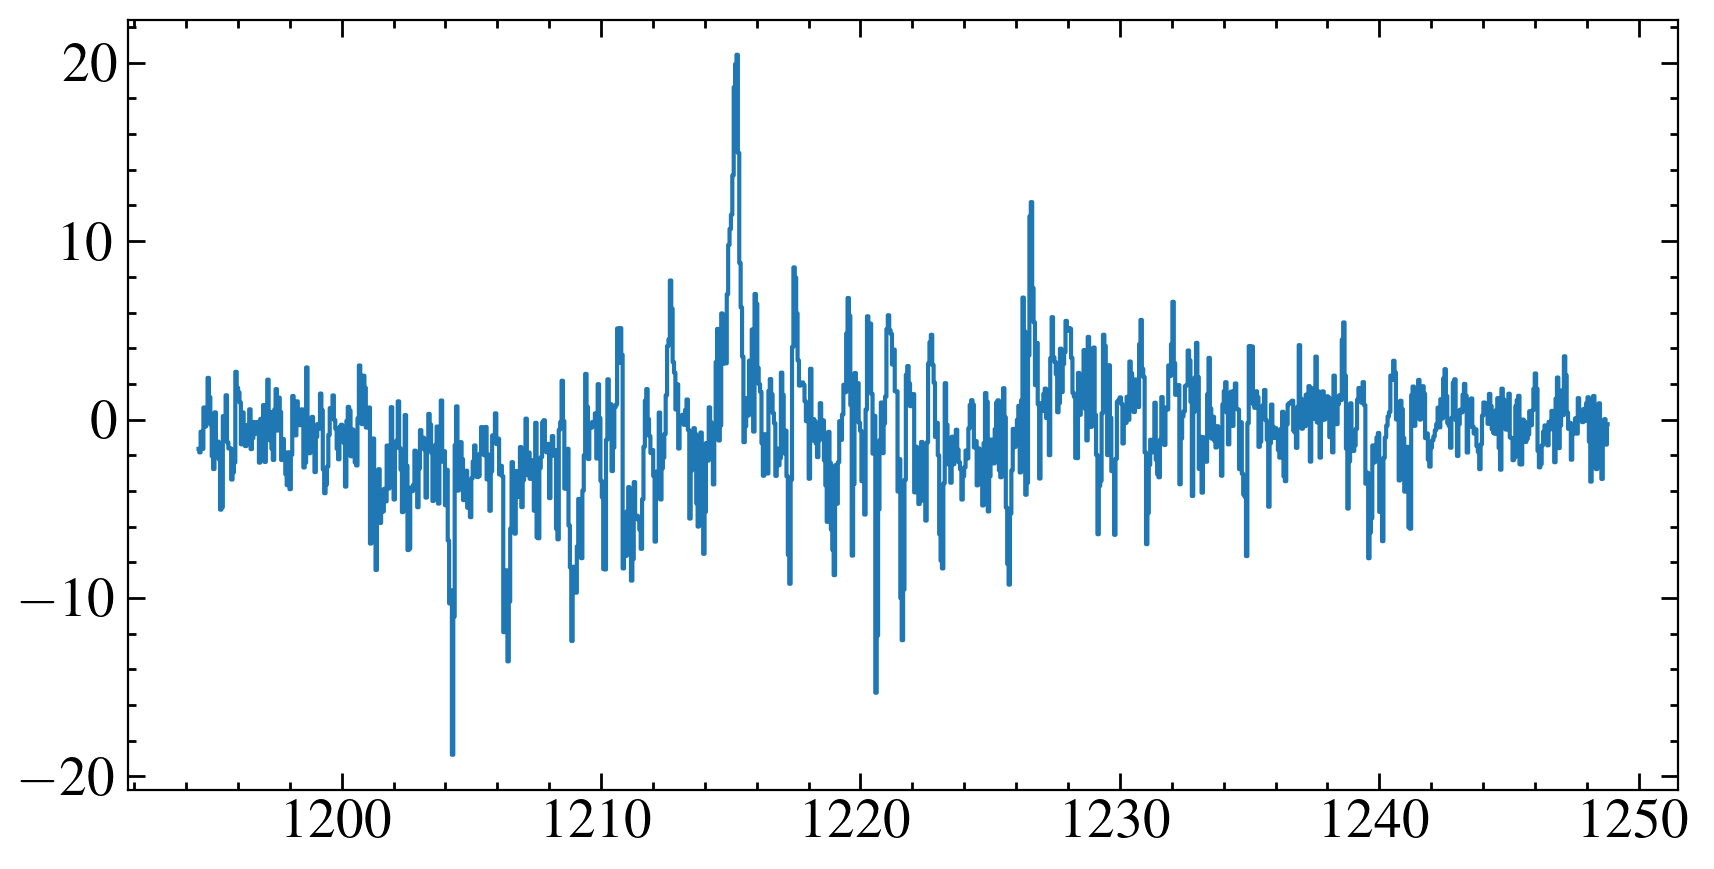

In [54]:
fig, ax = plt.subplots(figsize=(10, 5))


ax.step(w, f/e, where='mid',  zorder=10, label='FLUX')
print(np.max(f/e))